# Notebook for RL agent in trading, Multi Stock Environment

In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import quandl
import torch
yf.pdr_override() 

## Yahoo API

In [2]:
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'WMT','GS']

### Define the pêriod

In [3]:
# Define the time period for historical data
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 1, 1)

### Get data from web

In [4]:
data = pdr.get_data_yahoo(stocks, start=start_date, end=end_date)
data.head()

[*********************100%%**********************]  11 of 11 completed


Price       Adj Close                                                        \
Ticker           AAPL     AMZN      GOOGL          GS        JPM       META   
Date                                                                          
2015-01-02  24.435265  15.4260  26.477501  162.280441  48.549877  78.366852   
2015-01-05  23.746885  15.1095  25.973000  157.213608  47.042641  77.108192   
2015-01-06  23.749126  14.7645  25.332001  154.033234  45.822868  76.069290   
2015-01-07  24.082146  14.9210  25.257500  156.328812  45.892803  76.069290   
2015-01-08  25.007431  15.0230  25.345501  158.824600  46.918335  78.097137   

Price                                                  ...    Volume  \
Ticker           MSFT      NVDA       TSLA          V  ...      AMZN   
Date                                                   ...             
2015-01-02  40.378067  4.832577  14.620667  62.132988  ...  55664000   
2015-01-05  40.006752  4.750956  14.006000  60.761490  ...  55484000   
2015-01-06  39.419567  4.606914  14.085333  60.369965  ...  70380000   
2015-01-07  39.920406  4.594911  14.063333  61.178829  ...  52806000   
2015-01-08  41.094795  4.767761  14.041333  61.999367  ...  61768000   

Price                                                                  \
Ticker         GOOGL       GS       JPM      META      MSFT      NVDA   
Date                                                                    
2015-01-02  26480000  1877700  12600000  18177500  27913900  11368000   
2015-01-05  41182000  3413200  20100600  26452200  39673900  19795200   
2015-01-06  54456000  3429200  29074100  27399300  36447900  19776400   
2015-01-07  46918000  1896800  23843200  22045300  29114100  32180800   
2015-01-08  73054000  1962500  16971100  23961000  29645200  28378000   

Price                                     
Ticker          TSLA         V       WMT  
Date                                      
2015-01-02  71466000   8389600  13505400  
2015-01-05  80527500  12751200  20937000  
2015-01-06  93928500  11070000  24615300  
2015-01-07  44526000   9346800  25495200  
2015-01-08  51637500  10443200  38140800  

[5 rows x 66 columns]

### Save to CSV

In [5]:
data.to_csv('stock_prices.csv')

Create a dictionary and a list of the dataframes

In [6]:

stock_dataframes = {stock: data[[('Close', stock)]].copy() for stock in stocks}

WINDOW_SIZE = 30

for stock, df in stock_dataframes.items():
    df['moving_average'] = df['Close'].rolling(window=WINDOW_SIZE).mean()

dfs = [stock_dataframes[stock] for stock in stocks]



Plot the evolutoion of a stock price and its moving average

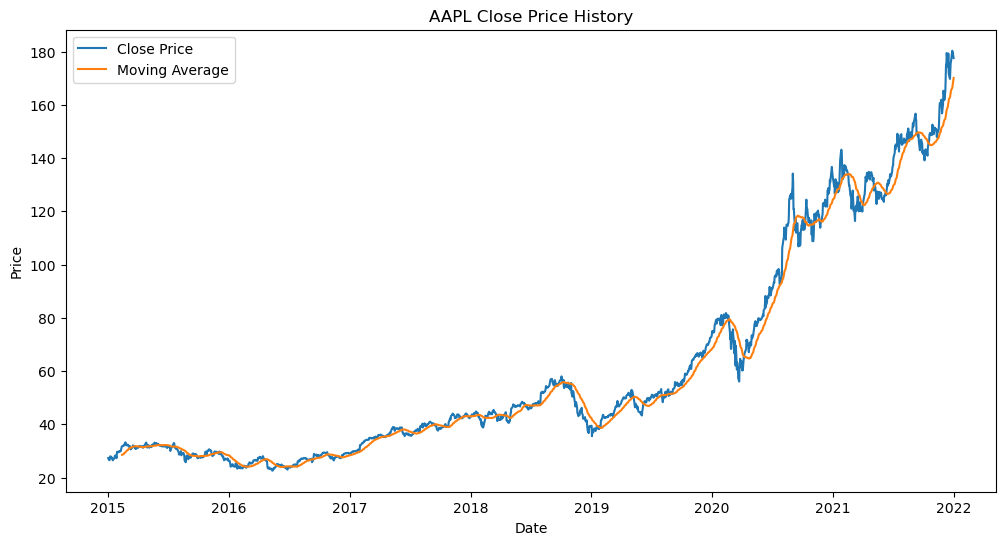

In [7]:
import matplotlib.pyplot as plt

stock_symbol = 'AAPL'
data = stock_dataframes[stock_symbol]

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['moving_average'], label='Moving Average')
plt.title(f'{stock_symbol} Close Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()




## Implement DQNetwork

### Parameters

In [8]:
from utils.agent_multidimensional import MultiStockAgent
from utils.env_multidimensional import MultiStockTradingEnv
from utils.dqn_multidimensional import MultiStockDQN
from utils.replay_buffer_multi import ReplayBufferMulti
from utils.epsilon_greedy_multi import EpsilonGreedyMulti
from utils.lr_scheduler import MinimumExponentialLR

# Parameters
T = 20 
price_list_size = T+1
sync_period=30
lr = 0.001
rb = 2000
es = 0.82
em = 0.013
ed = 0.9675
num_episodes=100
gamma=0.9
batch_size=128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device
num_stocks = len(stocks)


In [9]:
print("Creating Models ...")
model = MultiStockDQN(num_stocks,1, 1,num_stocks, device).to(device)
target_model = MultiStockDQN(num_stocks,1, 1,num_stocks, device).to(device)

#model = DQN(price_list_size, 1, 1, device).to(device)
#target_model = DQN(price_list_size, 1, 1, device).to(device)
print("... Models Created\n")

Creating Models ...
... Models Created



In [10]:
# initializing the optimizer, lr_scheduler and loss function
print("Creating Optimizer, LR Scheduler and Loss Function ...")
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
            # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()
print("... Optimizer, LR Scheduler and Loss Function Created\n")


Creating Optimizer, LR Scheduler and Loss Function ...


... Optimizer, LR Scheduler and Loss Function Created



In [11]:

# initializing the replay buffer
print("Creating Replay Buffer ...")
replay_buffer = ReplayBufferMulti(rb)
print("... Replay Buffer Created\n")

Creating Replay Buffer ...
... Replay Buffer Created



In [12]:




# initializing the environment
print("Creating Environment ...")
env = MultiStockTradingEnv(dfs, T=T,d=num_stocks)
print("... Environment Created\n")

# initializing the epsilon greedy strategy
print("Creating Epsilon Greedy Strategy ...")
epsilon_greedy = EpsilonGreedyMulti(epsilon_start=es, epsilon_min=em, epsilon_decay=ed, env=env, model=model)
print("... Epsilon Greedy Strategy Created\n")

# initializing the agent
print("Creating Agent ...")
agent = MultiStockAgent(env, model, target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
print("... agent Created\n")


Creating Environment ...
... Environment Created

Creating Epsilon Greedy Strategy ...
... Epsilon Greedy Strategy Created

Creating Agent ...
... agent Created



In [13]:
episode_reward_list = agent.train(num_episodes, gamma, batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

([2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0],)
tensor([[2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0]], device='cuda:0')
tensor([[[2],
         [1],
         [2],
         [0],
         [2],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0]]], device='cuda:0')
tensor([[[ 116.7119,  111.4801,   34.6814],
         [ -25.4394,   59.7250, -272.1813],
         [   0.6241, -253.7235,   29.6098],
         [-139.3052, -277.9013,  -50.9803],
         [-231.5860,   47.2906,   44.1534],
         [ -88.8458,  151.8493, -266.7538],
         [ 173.1757,  192.5559,   46.0025],
         [-157.8084,  218.5154,   60.8239],
         [ -91.9896,    1.8609,  193.6877],
         [ 158.3266,  277.4558,  171.3136],
         [  -2.9666,   42.0581, -116.0245]]], device='cuda:0',
       grad_fn=<ViewBackward0>)
([2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0], [2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 2])
tensor([[2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 0],
        [2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 2]], device='cuda:0')
tensor([[[2],
     

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

In [ ]:
a = dfs[0].iloc[0]['Close normalized'] 
b = float(a.iloc[0])
print(b)